# Parameters

In [1]:
#PARAMETERS

# model
Nep = 20
Nbatch = 2048

# bootstrap
APPLY_BOOTS = True
TRAIN_NN = True
NPULLS = 200
SAMPLE_SIZE=500_000 # reduce size of evaluation data

In [2]:
# Variables: Label
# drop out all events with Energies outside the range
LOWER_LIMIT = 100
UPPER_LIMIT = 10**5#10**5

# Variables: NN
NUM_BINS = 10#10 # number of bins (energy classes), output_shape

# Imports and setting seed for PRNG

In [3]:
import numpy as np
np.random.seed(42)

In [4]:
# data management
import os
import pandas as pd

# data processing
import tensorflow as tf
from sklearn import utils
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Read in feature list

In [5]:
path_featureList = '/net/nfshome/home/shaefs/bachelor_thesis_samuel_haefs/feature_selection/output/feature_importance.csv'
df_imp = pd.read_csv(path_featureList)
df_imp

,feature_name,feature_importance,std
0,I3MCWeightDict.OneWeight,0.466107,0.042258
1,I3MCWeightDict.TotalInteractionProbabilityWeight,0.088680,0.007833
2,SplineMPEDirectHitsD.dir_track_length,0.018239,0.009990
3,SplineMPEDirectHitsICB.n_late_doms,0.015740,0.009106
4,HitStatisticsValuesIC.q_tot_pulses,0.014089,0.010815
...,...,...,...
83,I3MCWeightDict.NEvents,0.000000,0.000000
84,weight_honda_h4a,0.000000,0.000000
85,weight_ERS_h3a,0.000000,0.000000
86,weight_ERS_h4a,0.000000,0.000000


In [6]:
feature_list = df_imp['feature_name'][2:69].tolist()

# Read in data

In [7]:
# just read-in necessary columns
fields = feature_list + ['MCPrimary.energy']

In [8]:
# read in data
file_path = '/net/big-tank/POOL/users/lkardum/new_mc_binning.csv'
df_raw = pd.read_csv(file_path, skipinitialspace=True, usecols=fields)

df_raw

,SplineMPE.zenith,SplineMPE.azimuth,SplineMPEFitParams.nmini,SPEFit2TimeSplit1FitParams.logl,SplineMPECramerRaoParams.variance_theta,SplineMPECramerRaoParams.covariance_theta_phi,SplineMPECramerRaoParams.covariance_theta_y,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,SPEFit2BayesianFitParams.nmini,MuEXAngular4_rllt.value,...,SplineMPE_MillipedeHighEnergyMIEFitParams.rlogl,SplineMPEDirectHitsD.dir_track_length,SPEFit2_HVFitParams.nmini,SplineMPETruncatedEnergy_SPICEMie_AllBINS_Muon.energy,LineFitGeoSplit2.zenith,SplineMPETruncatedEnergy_SPICEMie_AllBINS_Neutrino.energy,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.energy,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_dEdX.value
0,2.173209,1.450835,125.0,123.124257,0.000138,0.000037,-0.032945,20601.845970,231.0,7.049173,...,0.139320,685.779668,137.0,2526.835938,2.221959,40368.382177,1447.295371,0.175000,0.022686,0.131812
1,2.090220,2.636622,200.0,237.086697,0.003101,0.000668,0.033042,9461.487291,298.0,6.561541,...,0.099896,441.042202,92.0,630.132299,2.423724,20111.257701,479.612347,0.057143,0.097690,0.061557
2,2.152436,6.229766,206.0,38.646277,0.000325,-0.000076,-0.006858,43222.679757,345.0,6.417585,...,0.114078,693.142713,91.0,257.239972,2.078402,13655.266052,1131.508113,0.217391,0.049914,0.110715
3,1.526620,3.151964,229.0,63.513442,0.000066,-0.000123,-0.010941,9929.465219,196.0,6.490540,...,0.096490,812.617801,202.0,485.507753,1.602885,17895.872473,292.290969,0.875000,0.023061,0.044473
4,2.918809,4.037246,256.0,56.986199,0.001243,-0.000424,0.007623,14979.867844,266.0,5.739560,...,0.077930,481.401233,129.0,357.565624,3.141593,15674.452573,405.179483,0.294118,0.222784,0.055048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,2.172118,6.277671,219.0,49.769049,0.002613,-0.000850,0.019735,28988.905556,353.0,5.743283,...,0.119279,460.052098,80.0,4458.926101,2.299896,56523.447307,1148.094892,0.000000,0.149460,0.111854
13336409,1.793314,0.869684,279.0,218.336336,0.000112,-0.000024,-0.029691,13010.699980,702.0,6.835591,...,0.210637,687.935414,108.0,9210.806478,1.722485,93603.851895,716.027905,0.555556,0.134817,0.080649
13336410,2.338623,5.743147,314.0,73.113221,0.010503,-0.000857,-0.138076,15232.377792,269.0,6.303238,...,0.130154,450.014305,78.0,6471.678978,2.221949,72282.799275,996.351714,0.125000,0.090354,0.101285
13336411,2.297157,0.333139,214.0,84.905412,0.004765,0.002826,-0.028317,19444.610677,643.0,6.239686,...,0.093497,285.164319,81.0,1254.425580,1.728248,27903.240772,457.295637,0.000000,0.128185,0.059637


In [9]:
# drop critical rows
df = df_raw.drop([ 1007671,  1426233,  2304853,  2715790,  3674355,  3741687, 4178063,  4969266,  5038333,  5334552,  5589516,  5863719,
 5978972,  7006367,  7281704,  7509650,  8380383,  8758113,9043798, 10280382, 11179530, 11184928, 11332586, 11797767,12253944], axis = 0)

# substitute NaNs with extreme Value
df.fillna(value =-100000, inplace = True)

# Discretize the target Neutrino Energy

In [10]:
# throw out extreme high and low energy neutrinos
df = df[(df['MCPrimary.energy']<UPPER_LIMIT) & (df['MCPrimary.energy']>LOWER_LIMIT)]
df

,SplineMPE.zenith,SplineMPE.azimuth,SplineMPEFitParams.nmini,SPEFit2TimeSplit1FitParams.logl,SplineMPECramerRaoParams.variance_theta,SplineMPECramerRaoParams.covariance_theta_phi,SplineMPECramerRaoParams.covariance_theta_y,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,SPEFit2BayesianFitParams.nmini,MuEXAngular4_rllt.value,...,SplineMPE_MillipedeHighEnergyMIEFitParams.rlogl,SplineMPEDirectHitsD.dir_track_length,SPEFit2_HVFitParams.nmini,SplineMPETruncatedEnergy_SPICEMie_AllBINS_Muon.energy,LineFitGeoSplit2.zenith,SplineMPETruncatedEnergy_SPICEMie_AllBINS_Neutrino.energy,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.energy,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_dEdX.value
0,2.173209,1.450835,125.0,123.124257,0.000138,0.000037,-0.032945,20601.845970,231.0,7.049173,...,0.139320,685.779668,137.0,2526.835938,2.221959,40368.382177,1447.295371,0.175000,0.022686,0.131812
1,2.090220,2.636622,200.0,237.086697,0.003101,0.000668,0.033042,9461.487291,298.0,6.561541,...,0.099896,441.042202,92.0,630.132299,2.423724,20111.257701,479.612347,0.057143,0.097690,0.061557
2,2.152436,6.229766,206.0,38.646277,0.000325,-0.000076,-0.006858,43222.679757,345.0,6.417585,...,0.114078,693.142713,91.0,257.239972,2.078402,13655.266052,1131.508113,0.217391,0.049914,0.110715
3,1.526620,3.151964,229.0,63.513442,0.000066,-0.000123,-0.010941,9929.465219,196.0,6.490540,...,0.096490,812.617801,202.0,485.507753,1.602885,17895.872473,292.290969,0.875000,0.023061,0.044473
4,2.918809,4.037246,256.0,56.986199,0.001243,-0.000424,0.007623,14979.867844,266.0,5.739560,...,0.077930,481.401233,129.0,357.565624,3.141593,15674.452573,405.179483,0.294118,0.222784,0.055048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,2.172118,6.277671,219.0,49.769049,0.002613,-0.000850,0.019735,28988.905556,353.0,5.743283,...,0.119279,460.052098,80.0,4458.926101,2.299896,56523.447307,1148.094892,0.000000,0.149460,0.111854
13336409,1.793314,0.869684,279.0,218.336336,0.000112,-0.000024,-0.029691,13010.699980,702.0,6.835591,...,0.210637,687.935414,108.0,9210.806478,1.722485,93603.851895,716.027905,0.555556,0.134817,0.080649
13336410,2.338623,5.743147,314.0,73.113221,0.010503,-0.000857,-0.138076,15232.377792,269.0,6.303238,...,0.130154,450.014305,78.0,6471.678978,2.221949,72282.799275,996.351714,0.125000,0.090354,0.101285
13336411,2.297157,0.333139,214.0,84.905412,0.004765,0.002826,-0.028317,19444.610677,643.0,6.239686,...,0.093497,285.164319,81.0,1254.425580,1.728248,27903.240772,457.295637,0.000000,0.128185,0.059637


In [11]:
## log-scaled Binning
bins = np.logspace(np.log10(LOWER_LIMIT), np.log10(UPPER_LIMIT), NUM_BINS+1)
bins

array([   100.        ,    199.5262315 ,    398.10717055,    794.32823472,
         1584.89319246,   3162.27766017,   6309.5734448 ,  12589.25411794,
        25118.8643151 ,  50118.72336273, 100000.        ])

In [12]:
# new column with discretized energies

df['E_discr'] = pd.cut(df['MCPrimary.energy'], bins=bins, labels=range(len(bins)-1))
df['E_discr'].value_counts()

1    3265825
2    2971469
3    2110752
0    1939697
4    1327291
5     776316
6     435447
7     239490
8     128030
9      67777
Name: E_discr, dtype: int64

# Create target dataset

In [13]:
X = df[feature_list].to_numpy()
X.shape

(13262094, 67)

In [14]:
y = df['E_discr'].to_numpy()
y.shape

(13262094,)

In [15]:
# subsample size

def create_dataset(X, y, subset=0, validation_split=0.3):
    # X,y: numpy Array
    # subset: size of the subset (Int)
    # validation_split: (0, 1) 
    perm = np.random.permutation(len(X))

    if subset:
        perm = perm[0:subset]

    limit = int(len(perm)*(1-validation_split))

    X_train = X[perm[:limit]]
    X_eval = X[perm[limit:]]
    y_train = y[perm[:limit]]
    y_eval = y[perm[limit:]]

    return X_train, y_train, X_eval, y_eval

In [16]:
X_train, y_train, X_eval, y_eval = create_dataset(X, y, validation_split=0.1, subset=None)
print(X_train.shape, y_train.shape, X_eval.shape, y_eval.shape)

(11935884, 67) (11935884,) (1326210, 67) (1326210,)


In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_eval = scaler.transform(X_eval)

/opt/anaconda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


In [18]:
# reduce size of test set
y_eval = y_eval[0:SAMPLE_SIZE]
X_eval = X_eval[0:SAMPLE_SIZE]
X_eval.shape, y_eval.shape

((500000, 67), (500000,))

In [19]:
# need one hot encoded vector for softmax
y_train_hot = np.zeros((y_train.size, y_train.max()+1))
y_train_hot[np.arange(y_train.size),y_train] = 1

y_eval_hot = np.zeros((y_eval.size, y_eval.max()+1))
y_eval_hot[np.arange(y_eval.size),y_eval] = 1

# Build Neural Network

In [20]:
# neural network
def make_model(num_features, num_classes, learning_rate=0.0005):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(120, input_shape=num_features, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(240, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(12, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # compile the NN
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metric = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

    model.compile(optimizer=opt, loss=loss, metrics=[metric])

    return model

# Train the NN or load in weights

In [21]:
model = make_model((len(feature_list),), NUM_BINS, learning_rate=0.0005)

In [22]:
if TRAIN_NN:
    history = model.fit(X_train, y_train_hot, batch_size=Nbatch, epochs=Nep, validation_data=(X_eval, y_eval_hot))
    model.save_weights(f'models/{NUM_BINS}bins_{Nep}ep_{Nbatch}batches.h5')
    print(f'Saved model weights to /models/{NUM_BINS}bins_{Nep}ep_{Nbatch}batches.h5')
else:
    model.load_weights(f'models/{NUM_BINS}bins_{Nep}ep_{Nbatch}batches.h5')
    print(f'Load in model weights from /models/{NUM_BINS}bins_{Nep}ep_{Nbatch}batches.h5')

Train on 11935884 samples, validate on 500000 samples
Epoch 1/20
11935884/11935884 [==============================] - 21s 2us/sample - loss: 1.4927 - categorical_accuracy: 0.3962 - val_loss: 1.4635 - val_categorical_accuracy: 0.4062
Epoch 2/20
11935884/11935884 [==============================] - 19s 2us/sample - loss: 1.4585 - categorical_accuracy: 0.4085 - val_loss: 1.4515 - val_categorical_accuracy: 0.4108
Epoch 3/20
11935884/11935884 [==============================] - 19s 2us/sample - loss: 1.4513 - categorical_accuracy: 0.4113 - val_loss: 1.4479 - val_categorical_accuracy: 0.4122
Epoch 4/20
11935884/11935884 [==============================] - 19s 2us/sample - loss: 1.4473 - categorical_accuracy: 0.4128 - val_loss: 1.4456 - val_categorical_accuracy: 0.4129
Epoch 5/20
11935884/11935884 [==============================] - 19s 2us/sample - loss: 1.4446 - categorical_accuracy: 0.4139 - val_loss: 1.4440 - val_categorical_accuracy: 0.4137
Epoch 6/20
11935884/11935884 [=====================

# Evaluation with Bootstrap

In [23]:
if not APPLY_BOOTS:
    df_bootstrap = pd.read_csv(f'bootstrap_results/{NUM_BINS}bins_{Nit}it_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.csv')
    bootstrap_dsea = df_bootstrap.to_numpy()
    print('Read in bootstrap results.')
else:
    bootstrap_dsea = np.ndarray(shape=(NPULLS,NUM_BINS),dtype=float)
    for i in range(NPULLS):
        if (i+1)%10 ==0:
            print(i+1,' of ', NPULLS)

        # create random subsample of the evaluation data
        X_eval_bst, y_hot = utils.resample(X_eval, y_eval_hot, replace=True, n_samples=SAMPLE_SIZE, random_state=i)# bootstrap random sample from X_test

        # predict subsample
        y_pred_temp = model.predict(X_eval_bst)

        # save f_pred for each evaluation subsample
        bootstrap_dsea[i,:] = y_pred_temp.sum(axis=0)
    
    df_boots = pd.DataFrame(bootstrap_dsea)
    df_boots.to_csv(f'bootstrap_results/{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.csv', index=False)
    print(f'Bootstrap results saved: /bootstrap_results/{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.csv')

10  of  200
20  of  200
30  of  200
40  of  200
50  of  200
60  of  200
70  of  200
80  of  200
90  of  200
100  of  200
110  of  200
120  of  200
130  of  200
140  of  200
150  of  200
160  of  200
170  of  200
180  of  200
190  of  200
200  of  200
Bootstrap results saved: /bootstrap_results/10bins_20ep_500000samples_200pulls.csv


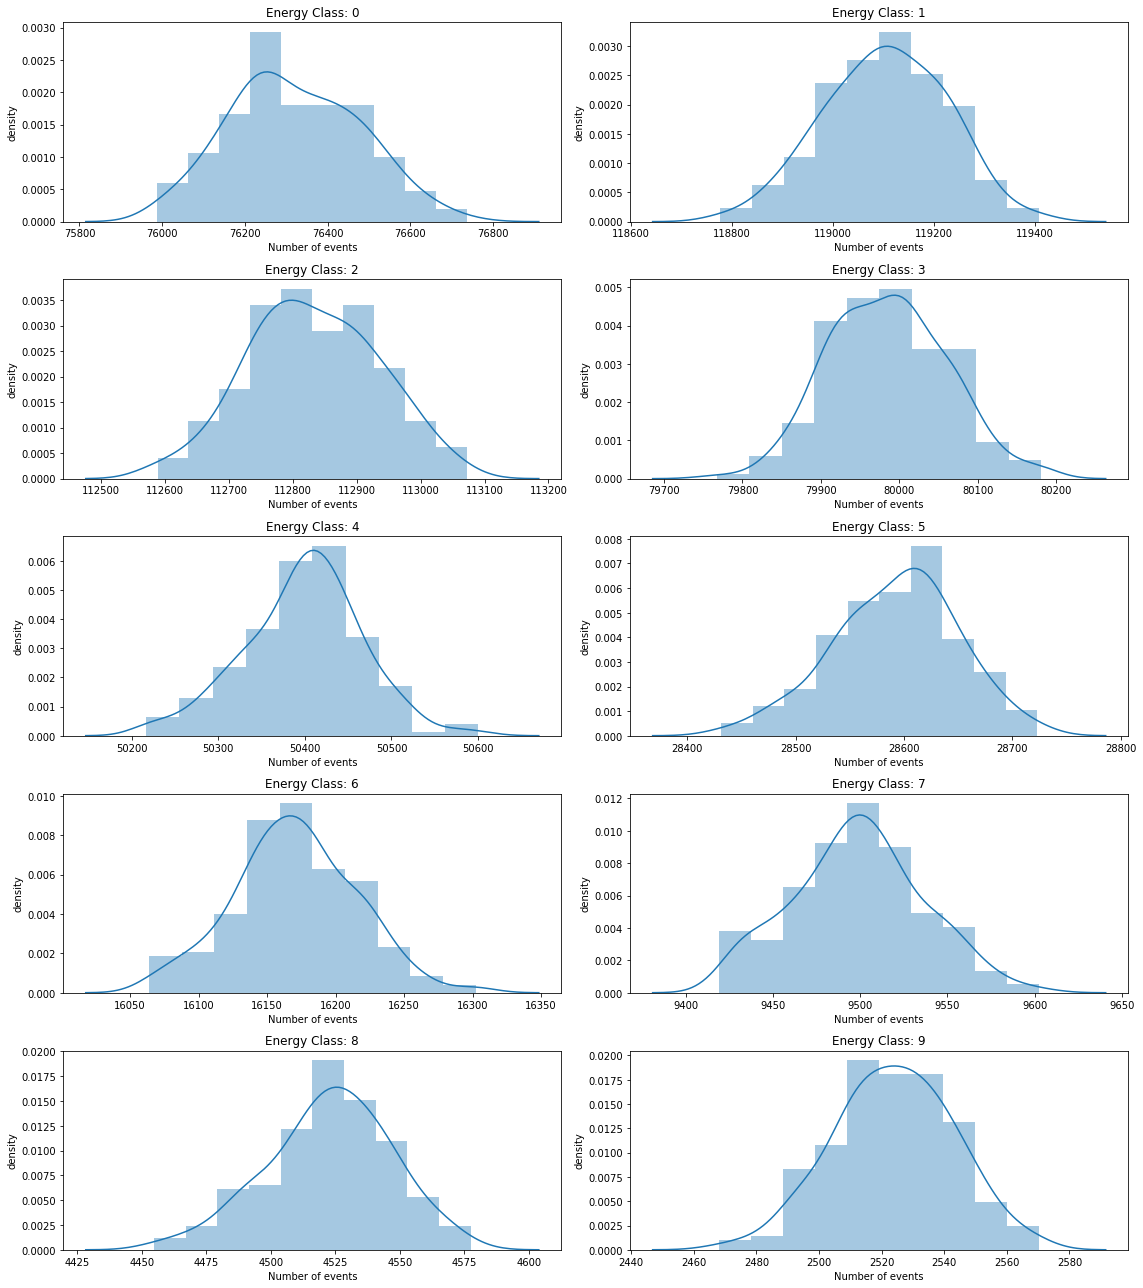

In [24]:
fig, axs = plt.subplots(5,2, figsize=(16,18))
for i in range(5):
    for j in range(2):
        sns.distplot(bootstrap_dsea[:,2*i+j], ax=axs[i,j], bins=10, kde=True, norm_hist=True)
        axs[i,j].set_xlabel('Number of events')
        axs[i,j].set_ylabel('density')

        axs[i,j].set_title(f'Energy Class: {2*i+j}')

plt.tight_layout()
plt.savefig(f'bootstrap_results/plots/class_dist_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)
plt.show()

In [25]:
boots_mean = bootstrap_dsea.mean(axis=0)
boots_mean_norm = boots_mean/boots_mean.sum()
boots_mean_norm

array([0.15265755, 0.23823171, 0.2256875 , 0.15998685, 0.10080728,
       0.05719088, 0.03234427, 0.01899946, 0.00904628, 0.00504823])

In [26]:
boots_std = bootstrap_dsea.std(axis=0)
boots_std_norm = boots_std/boots_mean.sum()
boots_std_norm

array([3.13116883e-04, 2.41512065e-04, 2.03514660e-04, 1.48745249e-04,
       1.36039853e-04, 1.14662698e-04, 8.92247699e-05, 7.46585233e-05,
       4.80218170e-05, 3.83616095e-05])

In [27]:
boots_median = np.median(bootstrap_dsea, axis=0)
boots_median_norm = boots_median/boots_median.sum()
boots_median_norm

array([0.15262856, 0.23823546, 0.22568247, 0.15999243, 0.10081636,
       0.05720557, 0.03234048, 0.01900095, 0.00904942, 0.0050483 ])

In [28]:
quantile_16 = np.quantile(bootstrap_dsea, 0.16, axis=0)
quantile_16_norm = quantile_16/boots_median.sum()
quantile_16_norm

array([0.15234038, 0.23797957, 0.22549567, 0.15984095, 0.10067027,
       0.05708022, 0.032261  , 0.01892262, 0.00899483, 0.00501191])

In [29]:
quantile_84 = np.quantile(bootstrap_dsea, 0.84, axis=0)
quantile_84_norm = quantile_84/boots_median.sum()
quantile_84_norm

array([0.15300199, 0.23847731, 0.22591176, 0.16014595, 0.10092695,
       0.05730214, 0.03243903, 0.01908101, 0.0090935 , 0.00508682])

In [30]:
boots_mean/boots_median

array([1.00019509, 0.99998943, 1.00002743, 0.99997032, 0.99991516,
       0.99974849, 1.00012222, 0.99992637, 0.99965831, 0.99999119])

# True distribution

In [31]:
_, f_true = np.unique(y_eval, return_counts=True)
f_true = f_true/len(y_eval)
f_true

array([0.147122, 0.246214, 0.224416, 0.15894 , 0.099776, 0.057786,
       0.032582, 0.018136, 0.00985 , 0.005178])

# Visualization of the spectrum

In [32]:
f_dsea = boots_median_norm

In [33]:
f_err = np.stack([f_dsea-quantile_16_norm, quantile_84_norm-f_dsea])
f_err

array([[2.88180457e-04, 2.55893745e-04, 1.86799818e-04, 1.51475268e-04,
        1.46083419e-04, 1.25342208e-04, 7.94841440e-05, 7.83305784e-05,
        5.45898936e-05, 3.63906742e-05],
       [3.73428054e-04, 2.41851560e-04, 2.29290789e-04, 1.53524871e-04,
        1.10590413e-04, 9.65758869e-05, 9.85503250e-05, 8.00594423e-05,
        4.40766552e-05, 3.85279625e-05]])

In [34]:
bins = np.logspace(np.log10(LOWER_LIMIT), np.log10(UPPER_LIMIT), NUM_BINS+1)
bin_centers = np.array([(bins[i] + (bins[i+1]-bins[i])/2) for i in range(NUM_BINS)])
bin_width = np.array([bins[i+1]-bins[i] for i in range(NUM_BINS)])

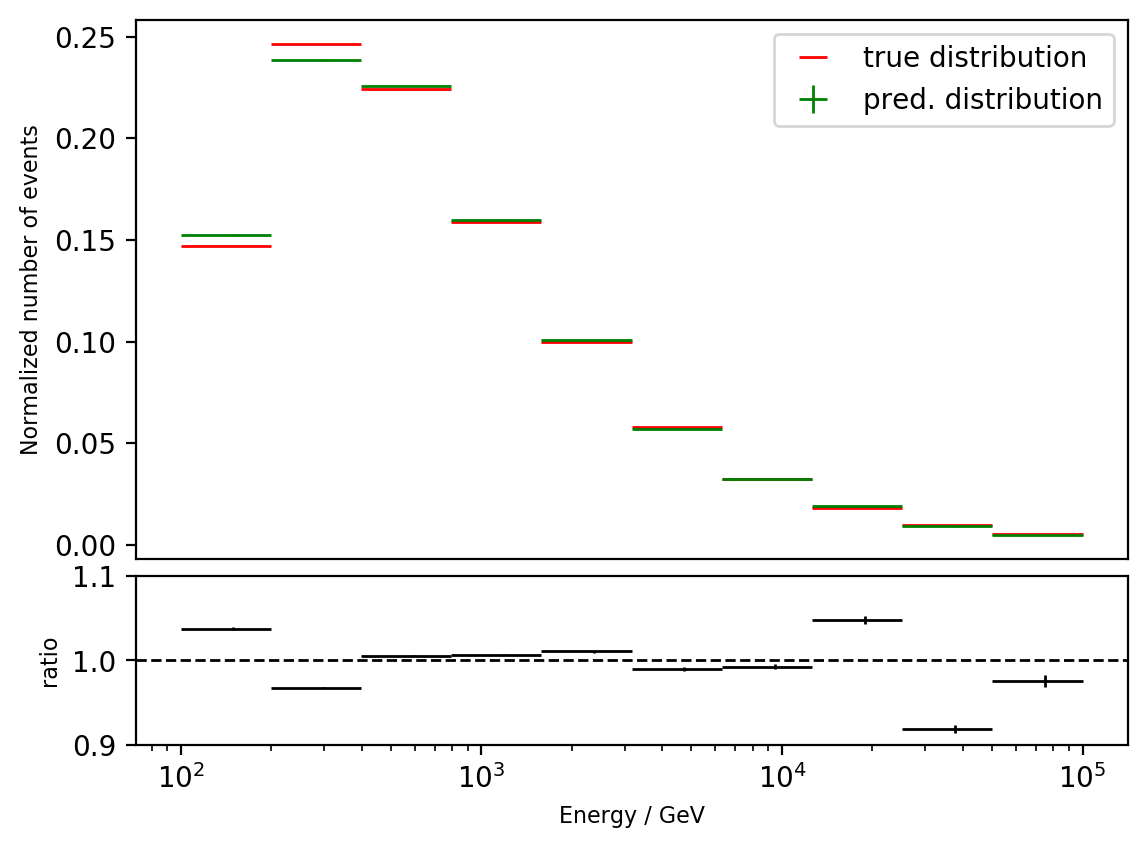

In [35]:
fig = plt.figure(figsize=(6.4,4.8),dpi=200) #dpi 300 for full hd
fig.tight_layout()

# seperation DSEA plot and ratio
gs = matplotlib.gridspec.GridSpec(4, 1)
axes1 = fig.add_subplot(gs[:-1])
axes2 = fig.add_subplot(gs[-1], sharex=axes1)
fig.subplots_adjust(hspace = .1) #0.001

# spectrum
axes1.errorbar(bin_centers, f_true, fmt=' ', color='red', xerr=bin_width/2, elinewidth=1, label='true distribution') #true distr
axes1.errorbar(bin_centers, f_dsea, fmt=' ', color='green', xerr=bin_width/2, yerr=f_err, elinewidth=1, label='pred. distribution') #pred. distr
axes1.set_xscale('log')
axes1.set_xticks([],[])
axes1.set_ylabel('Normalized number of events', fontsize=8)


# ratio
axes2.errorbar(bin_centers, f_dsea/f_true, fmt=' ', color='black', xerr=bin_width/2, yerr=f_err/f_true, elinewidth=1)
axes2.axhline(1, color='k', linestyle='--', linewidth=1)
axes2.set_xscale('log')
axes2.set_xlabel(r'Energy / GeV', fontsize=8)
axes2.set_yticks([0.9,1.0,1.1])
axes2.set_ylabel('ratio', fontsize=8)

# disable xticks in top plot
axes1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axes1.legend()


plt.savefig(f'bootstrap_results/plots/spectrum_dist_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)

plt.show()

In [36]:
chi2 = 0.5 * np.sum((f_dsea-f_true)**2 / (f_dsea+f_true))
chi2

0.00015226114550967402

# Prediction of single events

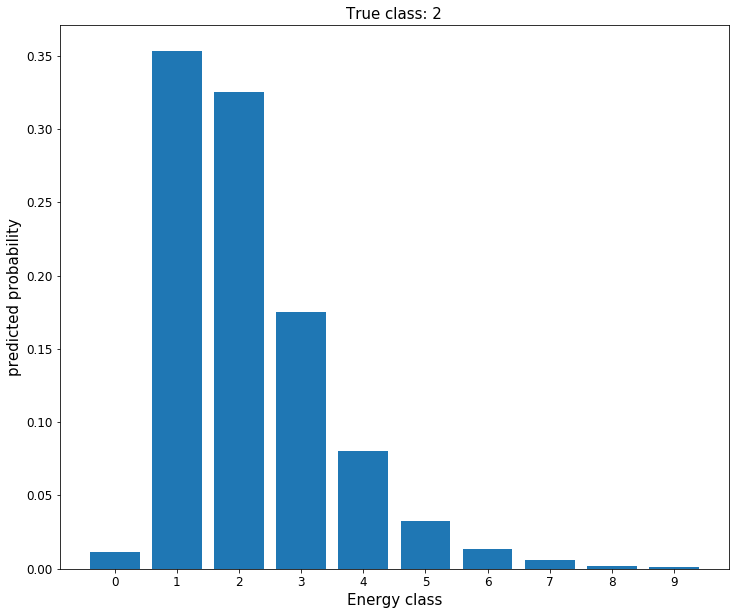

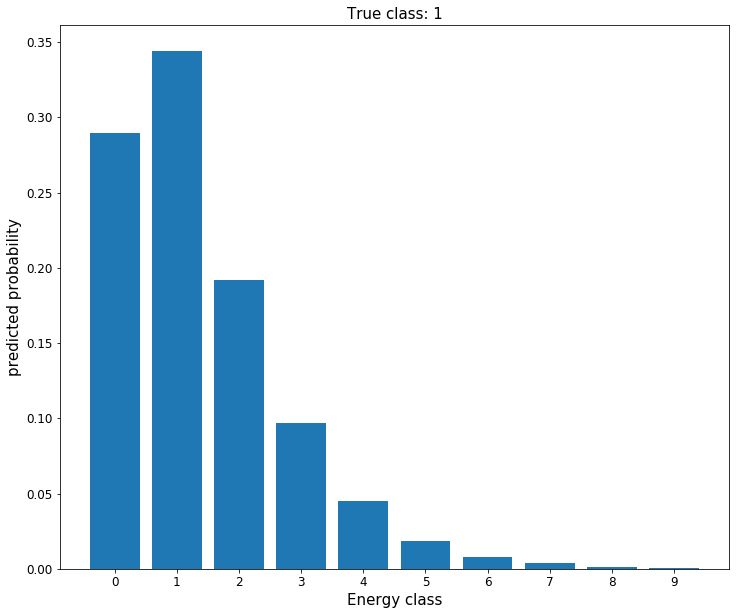

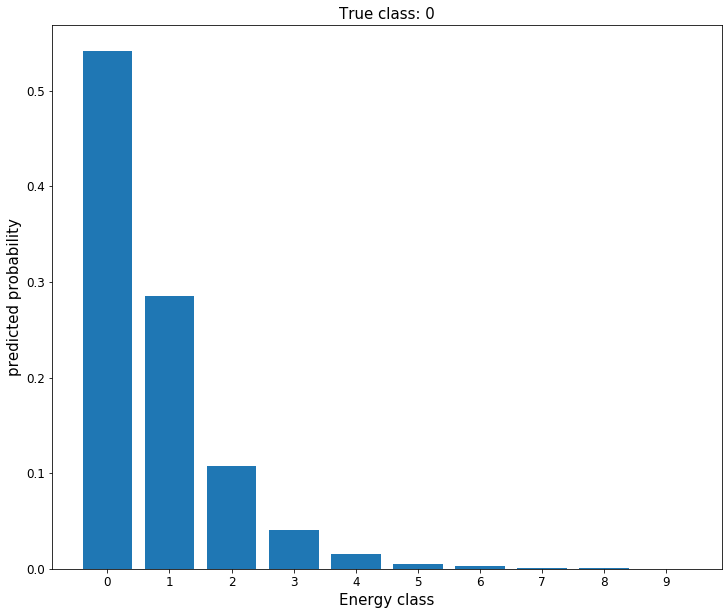

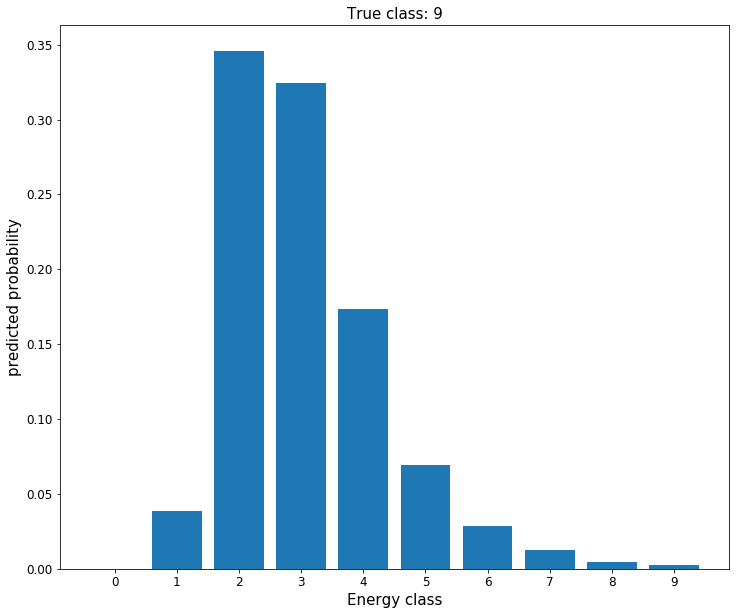

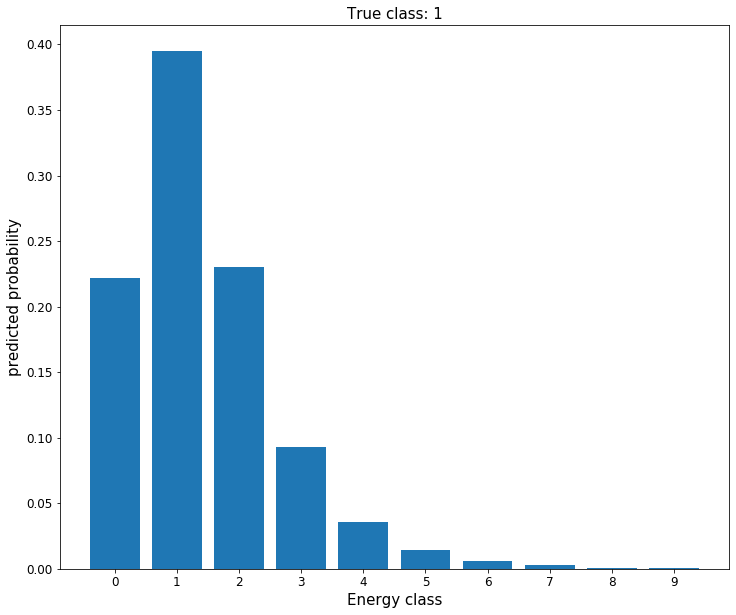

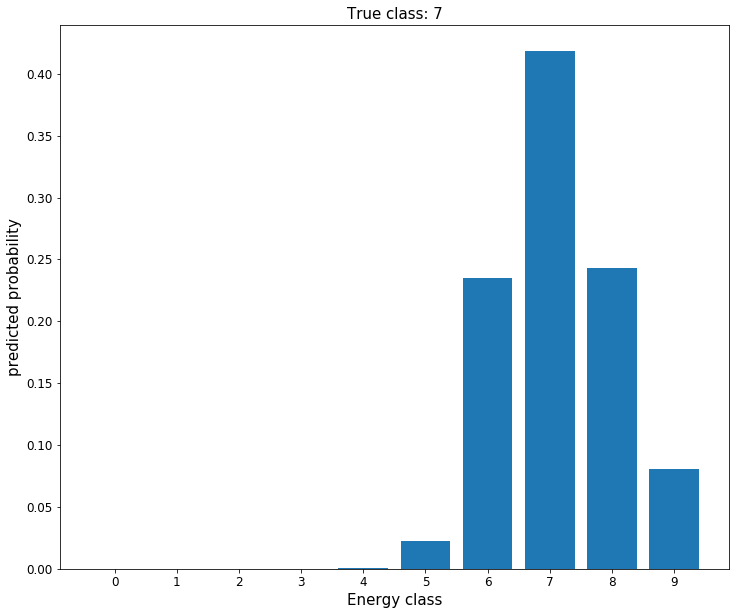

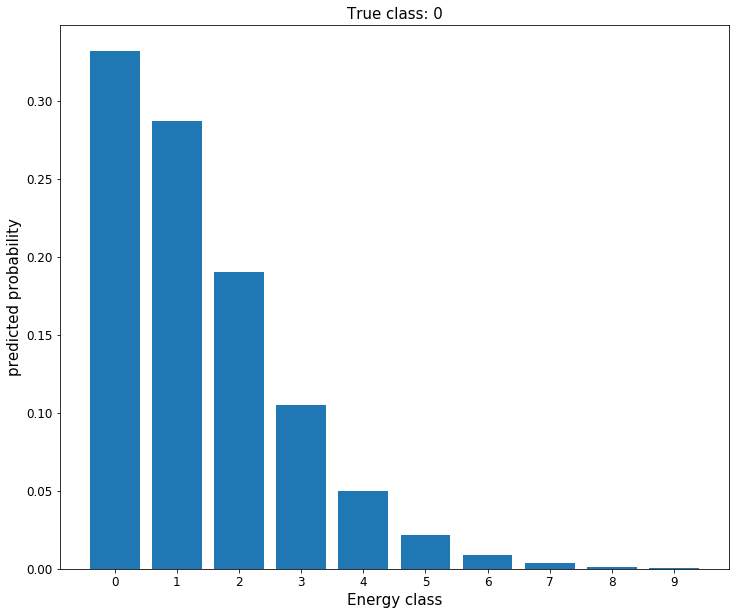

In [37]:
for ind_pred in np.arange(135,142):
    temp = model.predict(X_eval[ind_pred:ind_pred+1]).reshape(NUM_BINS,)

    plt.figure(figsize=(12,10))
    plt.bar(np.arange(NUM_BINS), temp)#np.arange(NUM_BINS), weights=temp, histtype='step'
    plt.title(f'True class: {y_eval[ind_pred]}', fontsize=15)
    plt.xticks(np.arange(NUM_BINS), fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Energy class', fontsize=15)
    plt.ylabel('predicted probability', fontsize=15)
    plt.show()

# Correlation matrix

In [38]:
y_pred = model.predict(X_eval)

In [39]:
y_pred_cls = np.argmax(y_pred, axis=1)

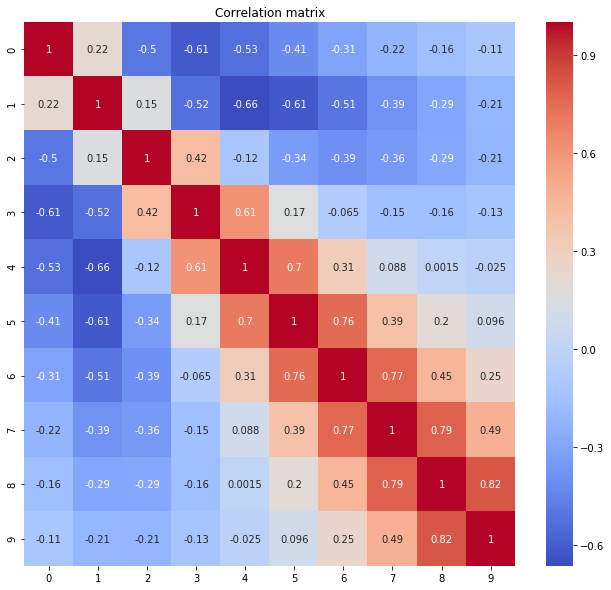

In [40]:
df_results = pd.DataFrame(data=y_pred)
plt.figure(figsize=(11,10))

ax = sns.heatmap(df_results.corr(), annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation matrix')
plt.savefig('output/correlation.png')

## Confusion Matrix

In [41]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_eval, y_pred_cls)

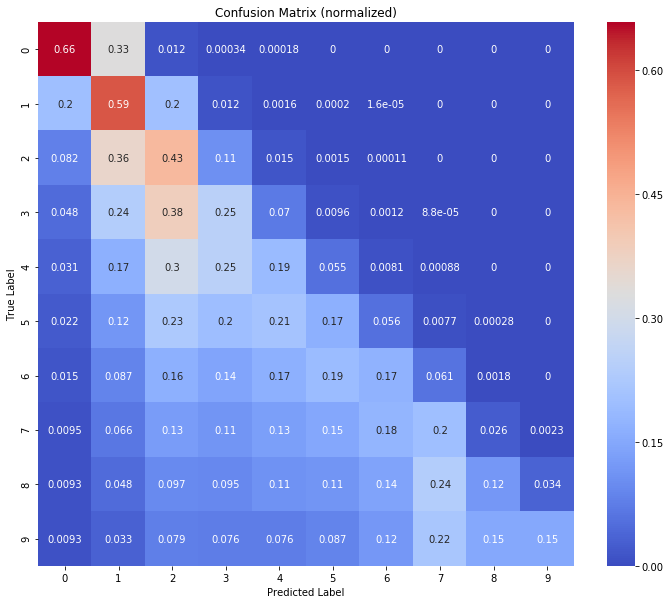

In [42]:
df_cm = pd.DataFrame(confusion_mtx/confusion_mtx.sum(axis=1)[:, np.newaxis])
plt.figure(figsize=(12,10))
#fix bug in matlotlib 3.1.0/1

ax = sns.heatmap(df_cm, annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (normalized)')
plt.savefig('output/cm_log2.pdf')
plt.show()

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
print('Evaluation on Evaluation data:\r')
print('Accuracy: %.4f' % accuracy_score(y_eval, y_pred_cls))
print("Precision: %.4f" % precision_score(y_eval, y_pred_cls, average='weighted'))
print("Recall: %.4f" % recall_score(y_eval, y_pred_cls, average='weighted'))
print(classification_report(y_eval, y_pred_cls))

Evaluation on Evaluation data:
Accuracy: 0.4182
Precision: 0.4073
Recall: 0.4182
              precision    recall  f1-score   support

           0       0.55      0.66      0.60     73561
           1       0.43      0.59      0.49    123107
           2       0.37      0.43      0.40    112208
           3       0.36      0.25      0.29     79470
           4       0.34      0.19      0.24     49888
           5       0.35      0.17      0.23     28893
           6       0.37      0.17      0.23     16291
           7       0.38      0.20      0.26      9068
           8       0.47      0.12      0.19      4925
           9       0.67      0.15      0.24      2589

    accuracy                           0.42    500000
   macro avg       0.43      0.29      0.32    500000
weighted avg       0.41      0.42      0.40    500000



In [44]:
from sklearn.metrics import jaccard_score
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
#'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account

jaccard_score = jaccard_score(y_eval, y_pred_cls, average='micro')
print('Jaccard-Score: %.4f' % jaccard_score)

Jaccard-Score: 0.2644
